In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
dir = '../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
label = []
path = []
for dirname, _,filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[1]=='.png':
            if dirname.split()[-1]!='GT':          
                label.append(os.path.split(dirname)[1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

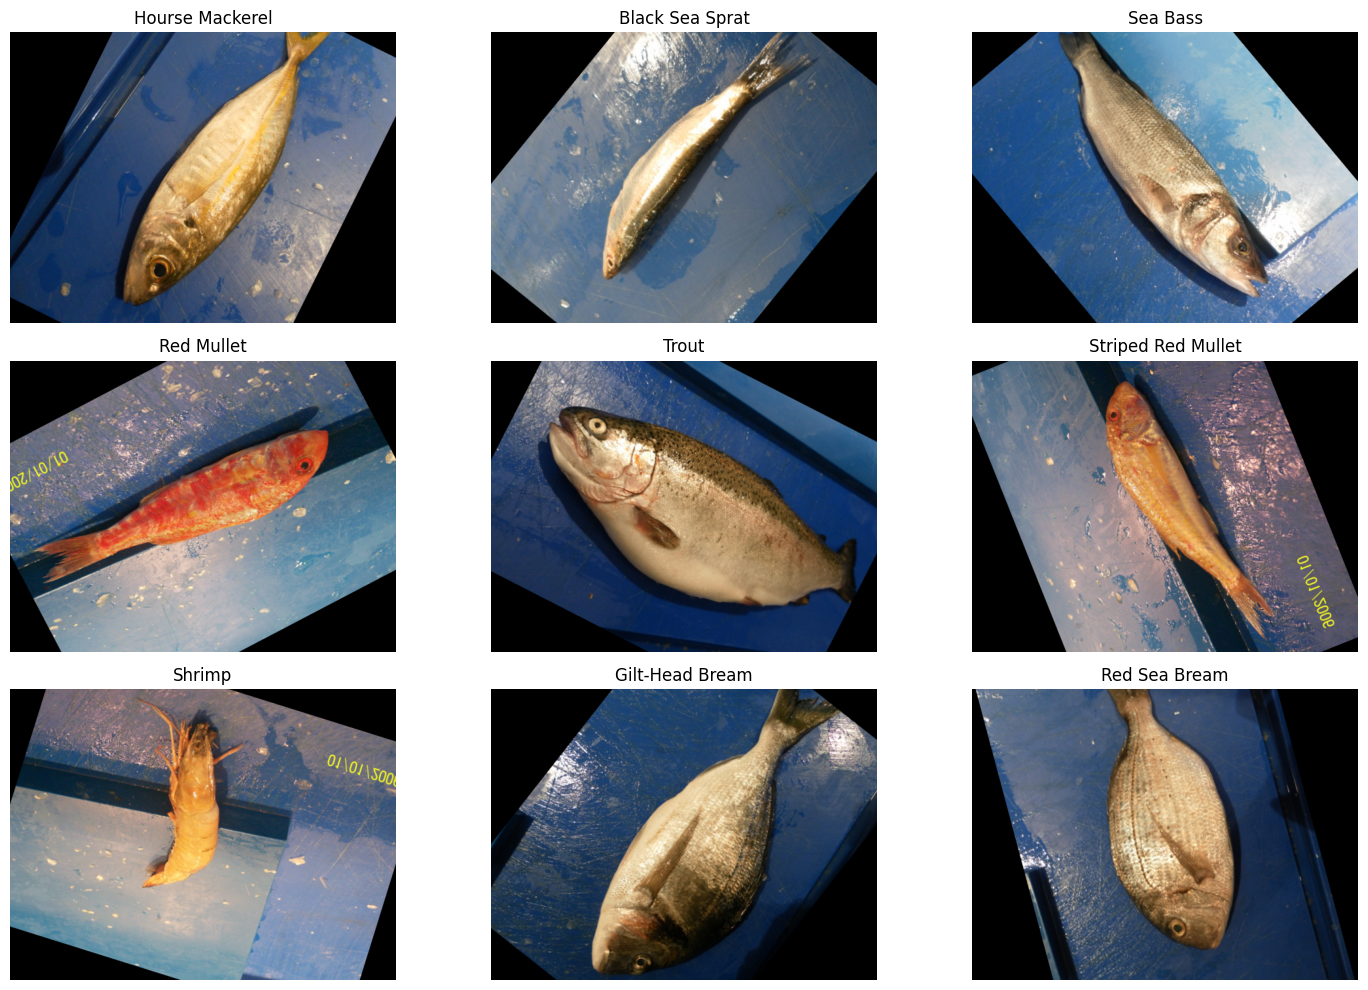

In [3]:
unique_labels = df['label'].unique()

# Her sınıftan bir örnek görüntü gösterelim
plt.figure(figsize=(15, 10))

for i, label in enumerate(unique_labels[:9]):  # İlk 9 sınıfı alalım
    # Bu sınıfa ait rastgele bir görüntü seçelim
    sample = df[df['label'] == label].sample(1).iloc[0]
    img_path = sample['path']
    
    # Görüntüyü yükleyelim
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Renk uzayını düzeltelim (BGR -> RGB)

    # Görüntüyü gösterelim
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [4]:
print(f" Satır Sayısı : {df.shape[0]} \n Sütun Sayısı : {df.shape[1]} ")


 Satır Sayısı : 9000 
 Sütun Sayısı : 2 


In [5]:
df['label'].value_counts(ascending=True)

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

# 1. Eğitim, Doğrulama ve Test Setlerine Ayırma:


In [6]:
# Önce eğitim ve geçerli test setini ayırıyoruz (80% eğitim, 20% test ve validation)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Sonra geçici test setini doğrulama ve test seti olarak ikiye ayırıyoruz (10% doğrulama, 10% test)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Sonuçların boyutlarını kontrol edelim
print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(val_df)}")
print(f"Test seti boyutu: {len(test_df)}")


Eğitim seti boyutu: 7200
Doğrulama seti boyutu: 900
Test seti boyutu: 900


In [22]:
# Görselleri ve etiketleri yükleme fonksiyonu
def load_images(df, img_size=(128, 128)):
    images = []
    labels = []
    
    for i, row in df.iterrows():
        img = cv2.imread(row['path'])
        img = cv2.resize(img, img_size)  # Görüntüleri yeniden boyutlandırıyoruz
        img = img / 255.0  # Normalizasyon (0-1 aralığına)
        images.append(img)
        labels.append(row['label'])
    
    images = np.array(images)
    labels = pd.Categorical(df['label']).codes  # Kategorik etiketleri numerik koda çeviriyoruz
    labels = to_categorical(labels)  # One-hot encoding (sınıfları bir vektör haline getirme)
    
    return images, labels

# Eğitim, doğrulama ve test verilerini yükleyelim
train_images, train_labels = load_images(train_df)
val_images, val_labels = load_images(val_df)
test_images, test_labels = load_images(test_df)

# Veri setlerinin boyutlarını kontrol edelim
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")


Train images shape: (7200, 128, 128, 3)
Validation images shape: (900, 128, 128, 3)
Test images shape: (900, 128, 128, 3)


In [95]:
import tensorflow as tf
from tensorflow.keras import backend as K

# TensorFlow oturumunu sıfırlama
K.clear_session()


In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Modeli oluşturalım
model = Sequential()
model.add(Flatten(input_shape=(128, 128, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,690,825 (48.41 MB)

 Trainable params: 12,690,825 (48.41 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

# Erken durdurma uygulamak
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1347 - loss: 3.1749 - val_accuracy: 0.2867 - val_loss: 1.8439
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2177 - loss: 1.9624 - val_accuracy: 0.3400 - val_loss: 1.7245
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3067 - loss: 1.7654 - val_accuracy: 0.4189 - val_loss: 1.5228
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3977 - loss: 1.5930 - val_accuracy: 0.5544 - val_loss: 1.2600
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4747 - loss: 1.3997 - val_accuracy: 0.5800 - val_loss: 1.1588
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5578 - loss: 1.2218 - val_accuracy: 0.5833 - val_loss: 1.2155
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5830 - loss: 1.1517 - val_accuracy: 0.6722 - val_loss: 0.8910
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6305 - loss: 1.0365 - val_acc

In [98]:
# Test seti üzerinde performansı kontrol edelim
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9221 - loss: 0.2360
Test Loss: 0.2650567591190338
Test Accuracy: 0.9155555367469788


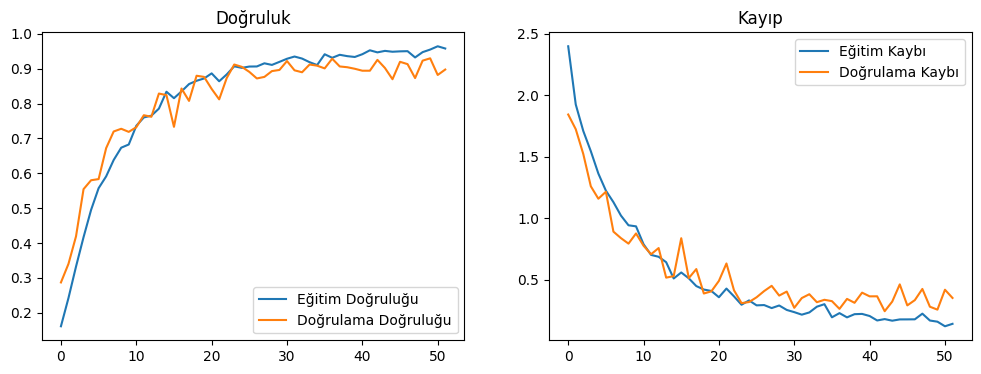

In [99]:
# Eğitim sürecini görselleştirelim
plt.figure(figsize=(12, 4))

# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk')
plt.legend()

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp')
plt.legend()

plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


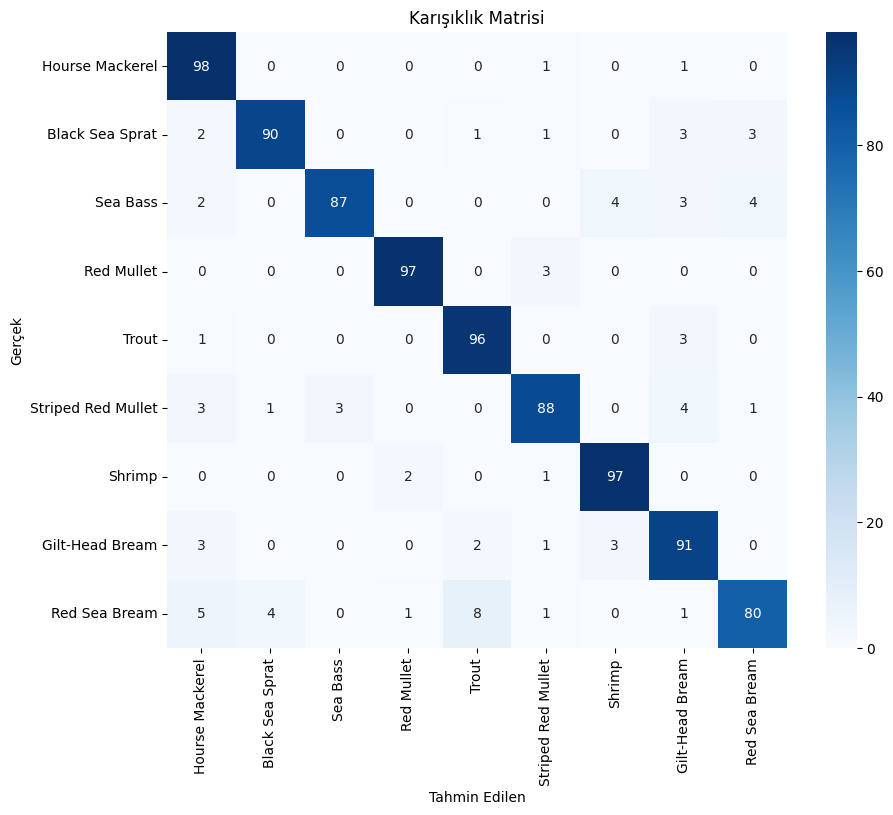

Sınıflandırma Raporu:

                    precision    recall  f1-score   support

   Hourse Mackerel       0.86      0.98      0.92       100
   Black Sea Sprat       0.95      0.90      0.92       100
          Sea Bass       0.97      0.87      0.92       100
        Red Mullet       0.97      0.97      0.97       100
             Trout       0.90      0.96      0.93       100
Striped Red Mullet       0.92      0.88      0.90       100
            Shrimp       0.93      0.97      0.95       100
   Gilt-Head Bream       0.86      0.91      0.88       100
     Red Sea Bream       0.91      0.80      0.85       100

          accuracy                           0.92       900
         macro avg       0.92      0.92      0.92       900
      weighted avg       0.92      0.92      0.92       900



In [100]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

# Test seti üzerinde tahminler yapalım
y_pred = model.predict(test_images)

# Tahmin edilen sınıfları alalım (en yüksek olasılığa sahip sınıf)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)  # Gerçek etiketler

# Karışıklık matrisi oluşturma
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

# Classification report oluşturma ve yazdırma
print("Sınıflandırma Raporu:\n")
print(classification_report(y_true, y_pred_classes, target_names=df['label'].unique()))
